In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = r"D:\UCSC\semester_02\2003\BA2003 Assignment 1\DATASET.csv"

df = pd.read_csv(file_path, encoding="utf-8-sig", low_memory=False)
print(df.shape)
print(df.head())


(541909, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

     InvoiceDate  UnitPrice  CustomerID         Country  
0  12/01/10 8:26       2.55     17850.0  United Kingdom  
1  12/01/10 8:26       3.39     17850.0  United Kingdom  
2  12/01/10 8:26       2.75     17850.0  United Kingdom  
3  12/01/10 8:26       3.39     17850.0  United Kingdom  
4  12/01/10 8:26       3.39     17850.0  United Kingdom  


In [3]:
# Remove cancellations in Invoice No

df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

#Drop missing Customer Id

df = df.dropna(subset = ['CustomerID'] )

#Remove invalid quantity and unit price
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Strip product names

df['Description'] = df['Description'].str.strip()


# Add Total price

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print(df.shape)
df.head

(397884, 9)


<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899          CHILDREN'S APRON DOLLY GIRL         6   
541906    581587     23254         CHILDRENS CUTLERY DOLLY GIRL         4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138         BAKING SET 9 PIECE RETROSPOT         3   

           InvoiceDate  UnitPrice  CustomerID


Top 10 Countries by Transactions:
Country
United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: count, dtype: int64



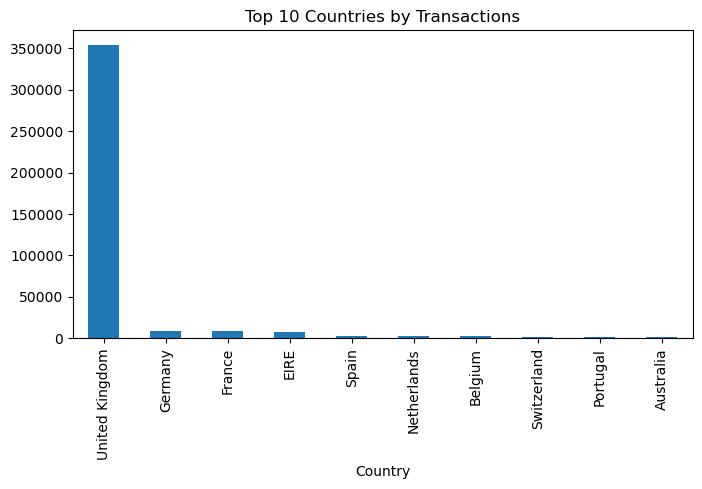


Top 10 Products:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1723
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1396
LUNCH BAG RED RETROSPOT               1316
SET OF 3 CAKE TINS PANTRY DESIGN      1159
LUNCH BAG  BLACK SKULL.               1105
POSTAGE                               1099
PACK OF 72 RETROSPOT CAKE CASES       1068
Name: count, dtype: int64


Top 10 Customers by Transactions:
CustomerID
17841.0    7847
14911.0    5675
14096.0    5111
12748.0    4595
14606.0    2700
15311.0    2379
14646.0    2076
13089.0    1818
13263.0    1677
14298.0    1637
Name: count, dtype: int64


Summary Statistics:
            Quantity      UnitPrice     TotalPrice
count  397884.000000  397884.000000  397884.000000
mean       12.988238       3.116488      22.397000
std       179.331775      22.097877     309.071041
min         1.000000       0.001000       0.001000
25% 

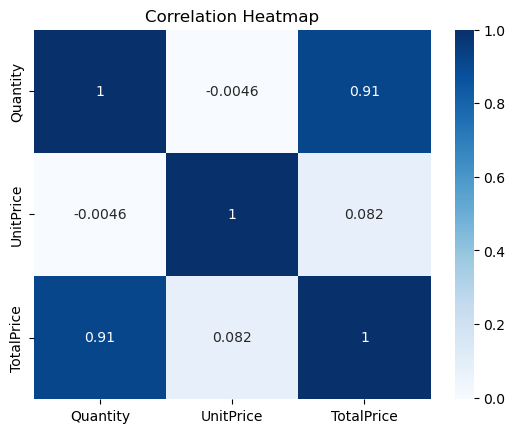

In [4]:
# -------------------------------
# Distribution Analysis
# -------------------------------

# Countries with most transactions - Top 10 countries
print("\nTop 10 Countries by Transactions:")
print(df['Country'].value_counts().head(10), end = "\n"*2)

df['Country'].value_counts().head(10).plot(kind='bar', figsize=(8,4), title="Top 10 Countries by Transactions")
plt.show()

# Most frequent products - Top 10 products
print("\nTop 10 Products:")
print(df['Description'].value_counts().head(10), end = "\n"*2)

# Customers with most purchases - Transactions per customer
print("\nTop 10 Customers by Transactions:")
print(df['CustomerID'].value_counts().head(10), end = "\n"*2)




# Statistical Exploration

print("\nSummary Statistics:")
print(df[['Quantity','UnitPrice','TotalPrice']].describe())




# Correlation Analysis


print("\nCorrelation Matrix:")
print(df[['Quantity','UnitPrice','TotalPrice']].corr())

sns.heatmap(df[['Quantity','UnitPrice','TotalPrice']].corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()

# Result: Dataset ready for Apriori



In [8]:
# Steps 2–4: Basket Creation + Apriori Rules

from mlxtend.frequent_patterns import apriori, association_rules

# --- Step 2: Top 3 Countries ---
top_countries = df['Country'].value_counts().head(3).index.tolist()
print("Top 3 countries:", top_countries)

# --- Step 3: Create Basket Function (optimized) ---
def create_basket(data, top_n_items=200):
    basket = (data.groupby(['InvoiceNo', 'Description'])['Quantity']
              .sum().unstack().fillna(0))
    # Convert to 1/0
    basket = (basket > 0).astype(bool)

    # Keep only most frequent items to save memory
    item_counts = basket.sum().sort_values(ascending=False)
    top_items = item_counts.head(top_n_items).index
    basket = basket[top_items]
    return basket

# --- Step 4: Apriori for each country ---
for country in top_countries:
    print("\n=== Country:", country, "===")
    country_data = df[df['Country'] == country]
    basket = create_basket(country_data, top_n_items=200)
    print(f"Transactions: {basket.shape[0]}, Items: {basket.shape[1]}")

    # Run Apriori
    frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
    if frequent_itemsets.empty:
        print("No frequent itemsets found.")
        continue

    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
    if rules.empty:
        print("No rules generated.")
        continue

    # Sort & show top 10 rules
    rules_sorted = rules.sort_values(['lift','confidence'], ascending=[False,False]).head(10)
    print(rules_sorted[['antecedents','consequents','support','confidence','lift']])


Top 3 countries: ['United Kingdom', 'Germany', 'France']

=== Country: United Kingdom ===
Transactions: 16646, Items: 200
                                          antecedents  \
61  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...   
66                  (GREEN REGENCY TEACUP AND SAUCER)   
65                   (PINK REGENCY TEACUP AND SAUCER)   
62  (ROSES REGENCY TEACUP AND SAUCER, GREEN REGENC...   
60                  (GREEN REGENCY TEACUP AND SAUCER)   
59                   (PINK REGENCY TEACUP AND SAUCER)   
63  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
64                  (ROSES REGENCY TEACUP AND SAUCER)   
56                  (GREEN REGENCY TEACUP AND SAUCER)   
55                  (ROSES REGENCY TEACUP AND SAUCER)   

                                          consequents   support  confidence  \
61                  (GREEN REGENCY TEACUP AND SAUCER)  0.020485    0.890339   
66  (ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY...  0.020485    0.557190   
65  (ROSES RE